# **The Navier-Stokes equations - ALE**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations using an ALE method, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [27]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License v2.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [28]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS
try:
    import dolfin
except ImportError as e:
    !apt-get install -y -qq software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    !sed -i "s|#if PETSC_VERSION_MAJOR == 3 && PETSC_VERSION_MINOR <= 8 && PETSC_VERSION_RELEASE == 1|#if 1|" /usr/include/dolfin/la/PETScLUSolver.h
    !rm -rf /usr/lib/python3/dist-packages/mpi4py*
    !rm -rf /usr/lib/python3/dist-packages/petsc4py*
    !rm -rf /usr/lib/python3/dist-packages/slepc4py*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/dolfin*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/mshr*
    !wget "https://drive.google.com/uc?export=download&id=1cT_QBJCOW_eL3BThnval3bcpb8o0w-Ad" -O /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=119i49bxlGn1mrnhTNmOvM4BqmjrT9Ppr" -O /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-1tVfu8qz3bRC2zvR8n3RESpesWqNnn6" -O /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-3qY4VIJQaXVO1HfGQIzTIURIeJbvX-9" -O /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-5SMjgjMuee_9WLeYtGe8N_lvipWEN7W" -O /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !pip3 install /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 -q install --upgrade sympy
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time Arbitrary Lagrangian-Eulerian (ALE) finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + ((u-w)\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term. The mesh velocity is denoted by w. 

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

In [29]:
# Experimental flags and parameters

DONT_MOVE = False

UPDATE_DIAMETER = False

USE_ELASTICITY = False

**Define domain and mesh**

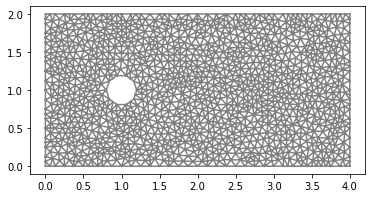

In [30]:
# Define rectangular domain 
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

Use piecewise linear polynomial approximation spaces.

In [31]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

Velocity is 1 at the inflow. The walls have slip boundary conditions, and the circular object have no-slip boundary conditions. The pressure is 0 at the outflow boundary.

In [32]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left) 
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration  
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

In [33]:
# Set viscosity
nu = 4.0e-3

**Define method parameters**

Create a sinusoidal expression for the mesh deformation at each time step.

If the function $sin(\pi y / H)$ is used in the vertical deformation, the cylinder will move upp and down in time. If we increase the frequency to $sin(2 \pi y / H)$ the cylinder will not move but instead only deform, since the function is 0 at the center of the circle (H/2).

In [34]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step  
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Define mesh deformation w, mesh velocity = w/dt
amp_x = 0.0
amp_y = 1.0e-2
freq = 0.1
t=0.0

if DONT_MOVE:
  w = Expression(("amp_x*sin(2.0*pi*t*freq)*sin(pi*x[0]/L)","amp_y*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*2*x[1]/H)"), L=L, H=H, t=t, amp_x=amp_x, amp_y=amp_y, freq=freq, element = V.ufl_element())
else:
  w = Expression(("amp_x*sin(2.0*pi*t*freq)*sin(pi*x[0]/L)","amp_y*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*x[1]/H)"), L=L, H=H, t=t, amp_x=amp_x, amp_y=amp_y, freq=freq, element = V.ufl_element())

# Set parameters for nonlinear and lienar solvers 
num_nnlin_iter = 5 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length 
dt = 0.5*mesh.hmin() 

**Define variational problem**

In [35]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*(um1-w/dt), v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*(um1-w/dt) + grad(p1), grad(v)*(um1-w/dt))*dx + d2*div(um)*div(v)*dx 
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*(um1-w/dt) + grad(p), grad(q))*dx + div(um1)*q*dx 
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

In [36]:
# Define the direction of the force to be computed 
phi_x = 1.0
phi_y = 0.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression_x = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi_x = interpolate(psi_expression_x, V)

Force_x = inner((u1 - u0)/dt + grad(um1)*um1, psi_x)*dx - p1*div(psi_x)*dx + nu*inner(grad(um1), grad(psi_x))*dx

phi_x = 0.0
phi_y = 1.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression_y = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi_y = interpolate(psi_expression_y, V)

Force_y = inner((u1 - u0)/dt + grad(um1)*um1, psi_y)*dx - p1*div(psi_y)*dx + nu*inner(grad(um1), grad(psi_y))*dx

D = 2*rc
normalization_y = -2.0/D

#plt.figure()
#plot(psi, title="weight function psi")


**Set plotting variables and open export files**

In [37]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 20

# Force computation data 
force_array_x = np.array(0.0)
force_array_x = np.delete(force_array_x, 0)
force_array_y = np.array(0.0)
force_array_y = np.delete(force_array_y, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Calculate elastic deformation**

Instead of deforming the whole mesh uniformly, we can simply move the cylinder and calculate the mesh deformation using the elasticity equations from the Elasticity notebook. The center of the cylinder is moved according to the temporal expression from the previous section, amp_y\*np.sin(2.0\*np.pi\*t\*freq-0.5\*np.pi).

In [38]:
def get_elastic_deformation(mesh, t):

  VEd = VectorElement("CG", mesh.ufl_cell(), 1)

  Vd = FunctionSpace(mesh, VEd)

  # Define trial and test functions
  ud = TrialFunction(Vd)
  vd = TestFunction(Vd) 

  d = Function(Vd)

  amp_y = 1.0e-2
  freq = 0.1

  bcu_left0_d = DirichletBC(V.sub(0), 0.0, dbc_left)
  bcu_left1_d = DirichletBC(V.sub(1), 0.0, dbc_left)
  bcu_right0_d = DirichletBC(V.sub(0), 0.0, dbc_right)
  bcu_right1_d = DirichletBC(V.sub(1), 0.0, dbc_right)
  bcu_upper0_d = DirichletBC(V.sub(0), 0.0, dbc_upper)
  bcu_upper1_d = DirichletBC(V.sub(1), 0.0, dbc_upper)
  bcu_lower0_d = DirichletBC(V.sub(0), 0.0, dbc_lower)
  bcu_lower1_d = DirichletBC(V.sub(1), 0.0, dbc_lower)
  bcu_obj0_d = DirichletBC(V.sub(0), 0.0, dbc_objects)
  bcu_obj1_d = DirichletBC(V.sub(1), amp_y*np.sin(2.0*np.pi*t*freq-0.5*np.pi), dbc_objects)
  bcu_d = [bcu_left0_d, bcu_left1_d, bcu_right0_d, bcu_right1_d, bcu_upper0_d, bcu_upper1_d, bcu_lower0_d, bcu_lower1_d, bcu_obj0_d, bcu_obj1_d]

  fd = Expression(("0.0","0.0"), element = Vd.ufl_element())

  dim = ud.geometric_dimension()
  E = 1e10;
  nu_d = 0.3;
  mu = E*0.5/(1+nu_d)
  lambda_ = nu_d*E/((1.0+nu_d)*(1.0-2.0*nu_d))

  def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)

  def sigma(u):
    #return 2.0*mu*epsilon(u)
    return lambda_*div(u)*Identity(dim) + 2.0*mu*epsilon(u)

  # Define variational problem on residual form: r(u,v) = 0
  residual_d = ( inner(sigma(ud), epsilon(vd))*dx - inner(fd, vd)*dx )

  au_d = lhs(residual_d)
  Lu_d = rhs(residual_d)

  A_d = assemble(au_d)
  b_d = assemble(Lu_d)

  [bc.apply(A_d, b_d) for bc in bcu_d]
  [bc.apply(d.vector()) for bc in bcu_d]

  solve(A_d, d.vector(), b_d, "bicgstab", "default")

  u1 = project(d, Vd)
  # Plot solution
  #plt.figure()
  #plot(u1, title="Displacement")
  #plt.show()

  return d

**Time stepping algorithm**

Solve NES via time stepping, while deforming the mesh in each time step either according to the sinusodial expression or via the elasticity equations.

In [39]:
!rm results-NS/*

# Time stepping 
T = 30
t = dt

upper_point = H/2 + rc;
lower_point = H/2 - rc;

if UPDATE_DIAMETER:
  if DONT_MOVE:
    mesh_deformation = lambda x: amp_y*np.sin(2.0*np.pi*t*freq-0.5*np.pi)*sin(np.pi*2*x/H)
  else:
    mesh_deformation = lambda x: amp_y*np.sin(2.0*np.pi*t*freq-0.5*np.pi)*sin(np.pi*x/H)

while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t) 
    #print(s)

    if UPDATE_DIAMETER:
      # Force normalization
      upper_point += mesh_deformation(upper_point)
      lower_point += mesh_deformation(lower_point)
      D = (upper_point - lower_point)
      normalization_x = -2.0/D
    else:
      normalization_x = normalization_y

    pin.t = t
    #uin.t = t

    if USE_ELASTICITY:
      d = get_elastic_deformation(mesh, t);
      ALE.move(mesh, d)
    else:
      w.t = t
      ALE.move(mesh, w)

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble momentum matrix and vector 
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution 
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap) 
        bp = assemble(Lp)

        # Compute pressure solution 
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F_x = assemble(Force_x)
        F_y = assemble(Force_y)
        if (t > start_sample_time):
          force_array_x = np.append(force_array_x, normalization_x*F_x)
          force_array_y = np.append(force_array_y, normalization_y*F_y)
          time = np.append(time, t)

        k += 1

    if t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)
        print('D = ' + repr(D) )
        print(np.sin(2.0*np.pi*t*freq-0.5*np.pi));
    
        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plt.figure()
        plot(mesh, title="Mesh")
        
        plot_time += T/plot_freq
        
        plt.show()

        if DONT_MOVE:
          txt="(non-moving cylinder)"
        else:
          txt="(moving cylinder)"

        plt.figure()
        plt.title("Lift force")
        plt.plot(time, force_array_y)
        plt.figtext(0.5, -0.04, txt, wrap=True, horizontalalignment='center', fontsize=14)
        plt.xlabel('time');
        plt.show()

        plt.figure()
        plt.title("Drag force")
        plt.plot(time, force_array_x)
        plt.xlabel('time');
        if UPDATE_DIAMETER: txt += " (dynamic diameter)"
        plt.figtext(0.5, -0.04, txt, wrap=True, horizontalalignment='center', fontsize=14)
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

Output hidden; open in https://colab.research.google.com to view.

---

# Figure 1

Drag and lift forces on the moving cylinder

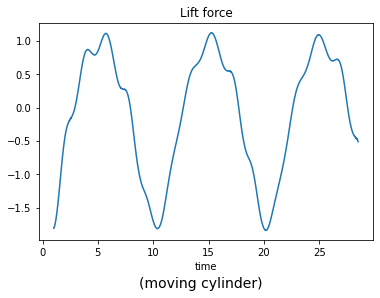

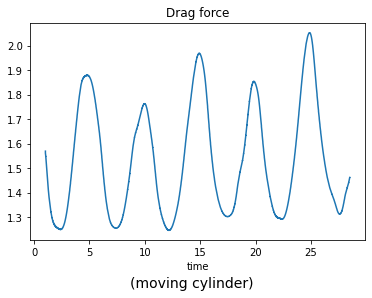

---

#Figure 2

Drag and lift forces on the non-moving cylinder.

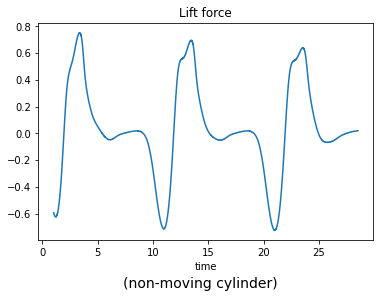

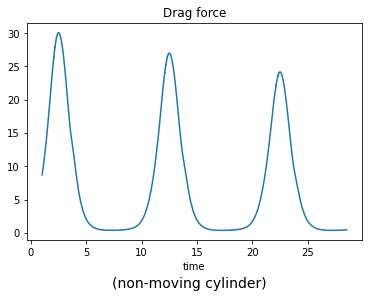

---

#Figure 3

Some examples the mesh deformation when using elastic deformation.



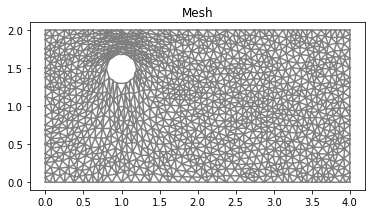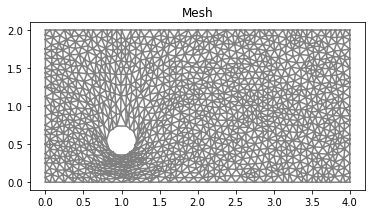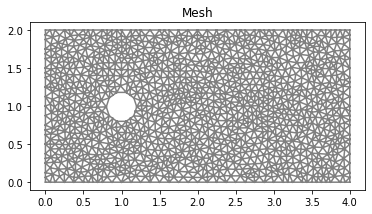

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D using an ALE finite element method.

The resulting drag and lift forces on a moving cylinder can be seen in Figure 1. We see that the lift forces oscillates up and down as the cylinder moves. Both the drag force and the (absolute) lift force appears to reach their peak when the cylinder is stationary and changes directions.

The resulting drag and lift forces on a non-moving but deforming cylinder can be seen in Figure 2. The deformation causes the cylinder to become very heigh, resulting in large drag forces, and very thin, resulting in very small drag forces.

**Dynamic diameter**

I though it was a bit suspect to use the same diameter at every time step when calculating drag, since the diameter changes with time due to deformation. If I remember correctly the purpose of normalization is to get the drag coefficent, but now it is not calculating the coefficent but simply the total force scaled by the initial diameter, which sort of defeats the purpose of normalizing I think. I also implemented an algorithm that calculates what I hope is the correct coefficent by updating the diameter the same way the mesh is updated. The results for the non-moving mesh can be seen below.

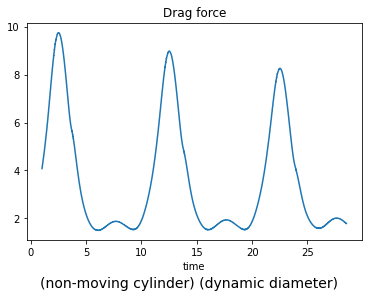

**Elastic mesh deformation**

A elastically deforming mesh was implemented in the same manner as in the Elasticity notebook. Some examples from the elastic mesh deformation can be seen in Figure 3. 